<a href="https://colab.research.google.com/github/MagalyCabrera8/Produccion-/blob/main/Gesti%C3%B3nInventarios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

\ **DATOS FIJOS PARA TODO EL EJERCICIO**

In [ ]:
#DATOS FIJOS
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tabulate import tabulate

d_hist = [
    150, 230, 160, 120, 400, 185, 126, 250, 240, 185,
    138, 190, 112, 295, 152, 160, 199, 136, 274, 210,
    189, 213, 120, 127, 300, 150, 173, 192, 112, 152,
    120, 100, 273, 188, 193, 98, 120, 120, 262, 111,
    123, 217, 220, 251, 180, 206, 200, 300, 170, 230] # Demanda histórica para 50 días
d_prom = np.mean(d_hist) #Demanda promedio ud/día
dev = np.std(d_hist,ddof=1) # Desviación estandar muestral
Cos_al = 3.5 # Costo de almacenar [$/ud]
Cos_Inex = 5 #Costo inexistencias [$/ud]
demanda = np.asarray([220, 470, 365, 260, 290, 205, 250, 200, 415, 180, 430, 460, 400, 345, 450]) #Pronóstico de la demanda para 15 días



# **FUNCIÓN DE KARDEX**

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tabulate import tabulate
import itertools


def SinBackOrders (Q,Ns,Lt):

  d_hist = [
      150, 230, 160, 120, 400, 185, 126, 250, 240, 185,
      138, 190, 112, 295, 152, 160, 199, 136, 274, 210,
      189, 213, 120, 127, 300, 150, 173, 192, 112, 152,
      120, 100, 273, 188, 193, 98, 120, 120, 262, 111,
      123, 217, 220, 251, 180, 206, 200, 300, 170, 230] # Demanda histórica para 50 días
  d_prom = np.mean(d_hist) #Demanda promedio ud/día
  dev = np.std(d_hist,ddof=1) # Desviación estandar muestral
  Cos_al = 3.5 # Costo de almacenar [$/ud]
  Cos_Inex = 5 #Costo inexistencias [$/ud]
  demanda = np.asarray([220, 470, 365, 260, 290, 205, 250, 200, 415, 180, 430, 460, 400, 345, 450]) #Pronóstico de la demanda para 15 días
  z= norm.ppf(Ns) #Cálculo de z a partir del nivel de servicio
  R = int(np.ceil(d_prom * Lt + z*dev*(Lt)**(1/2)))

  dias = np.arange(1, 16)
  inv_bodega = np.zeros(15, dtype=int)
  inv_bodega[0] = 1200   # Día 1 arranca con 1200
  inv_transito = np.zeros(15, dtype=int)
  inv_total = np.zeros(15, dtype=int)
  orden_pedidos = np.zeros(15, dtype=int)
  recepcion_pedidos = np.zeros(15, dtype=int)
  ud_no_vendidas = np.zeros(15, dtype=int)

  df = pd.DataFrame({
      "Día": dias,
      "Demanda": demanda,
      "Inv. Bodega": inv_bodega,
      "Inv. Tránsito": inv_transito,
      "Inv. Total": inv_total,
      "Orden Pedidos": orden_pedidos,
      "Recepción de pedidos": recepcion_pedidos,
      "Ud. No vendidas": ud_no_vendidas})

  bodega = 1200
  recepciones_prog = {}
  transito_inicio = 0

  i = 0
  while i < len(df):
      dia = int(df.loc[i, "Día"])
      dem = int(df.loc[i, "Demanda"])

      # 1) ¿Llega algo HOY? -> registrar recepción y sumar a bodega
      recep_hoy = recepciones_prog.pop(dia, 0)          # 0 si no hay llegada hoy
      df.loc[i, "Recepción de pedidos"] = int(recep_hoy)

      # Store inventory before reception
      inv_bodega_before_reception = bodega

      bodega += recep_hoy                                # lo recibido hoy ya está en bodega

      # 2) Inv. Bodega mostrado para HOY (antes de vender)
      df.loc[i, "Inv. Bodega"] = int(bodega)

      # 3) Tránsito de HOY = pedidos que llegarán en días > dia (no cuenta lo que llega hoy)
      #    Tampoco cuenta el pedido que HACES hoy (ese empezará a estar en tránsito desde mañana).
      transito_hoy = sum(q for d_llega, q in recepciones_prog.items() if d_llega > dia)
      df.loc[i, "Inv. Tránsito"] = int(transito_hoy)

      # 4) Total para decidir si pides
      inv_total_para_decidir = bodega + transito_hoy
      df.loc[i, "Inv. Total"] = int(inv_total_para_decidir)

      # Insert duplicated row if there was a reception
      if recep_hoy > 0:
          new_row = df.loc[i].copy()
          new_row["Inv. Bodega"] = inv_bodega_before_reception
          new_row["Recepción de pedidos"] = int(recep_hoy) # Keep reception in the first row
          new_row["Inv. Tránsito"] = int(transito_hoy)
          new_row["Inv. Total"] = int(inv_bodega_before_reception + transito_hoy) # Calculate total before adding reception
          new_row["Orden Pedidos"] = 0 # No order decision in the first row
          new_row["Ud. No vendidas"] = 0 # No sales in the first row


          df = pd.concat([df.iloc[:i], pd.DataFrame([new_row]), df.iloc[i:]]).reset_index(drop=True)
          i += 1 # Increment index to process the inserted row next

          # Update the current row after reception
          df.loc[i, "Inv. Bodega"] = int(bodega)
          df.loc[i, "Inv. Tránsito"] = int(transito_hoy)
          df.loc[i, "Inv. Total"] = int(inv_total_para_decidir)
          df.loc[i, "Recepción de pedidos"] = 0 # Reception is already accounted for in the previous row


      # 5) ¿Pido HOY? Si Total < R -> orden Q; se PROGRAMA llegada a dia + Lt
      if inv_total_para_decidir < R:
          df.loc[i, "Orden Pedidos"] = int(Q)
          dia_llegada = dia + int(Lt)
          recepciones_prog[dia_llegada] = recepciones_prog.get(dia_llegada, 0) + int(Q)
          # Nota: NO tocamos Inv. Tránsito hoy; empezará a verse a partir de mañana.
      else:
          df.loc[i, "Orden Pedidos"] = 0

      # 6) Vender para cerrar el día y dejar bodega lista para el día siguiente
      vendidos = min(bodega, dem)
      no_vendidas = dem - vendidos
      bodega -= vendidos
      df.loc[i, "Ud. No vendidas"] = int(no_vendidas)

      i += 1
  inv_promedio = df["Inv. Bodega"].sum() / df["Día"].iloc[-1]
  can_no_venidas = df["Ud. No vendidas"].sum()
  costo_almacenaje = inv_promedio * Cos_al
  costo_inexistencias = can_no_venidas * Cos_Inex
  costo_total = costo_almacenaje + costo_inexistencias
  return df, inv_promedio, costo_almacenaje, can_no_venidas, costo_inexistencias, costo_total,R

**ESCENARIO A**

ESCENARIO A
╒═══════╤═══════════╤═══════════════╤═════════════════╤══════════════╤═════════════════╤════════════════════════╤═══════════════════╕
│   Día │   Demanda │   Inv. Bodega │   Inv. Tránsito │   Inv. Total │   Orden Pedidos │   Recepción de pedidos │   Ud. No vendidas │
╞═══════╪═══════════╪═══════════════╪═════════════════╪══════════════╪═════════════════╪════════════════════════╪═══════════════════╡
│     1 │       220 │          1200 │               0 │         1200 │               0 │                      0 │                 0 │
├───────┼───────────┼───────────────┼─────────────────┼──────────────┼─────────────────┼────────────────────────┼───────────────────┤
│     2 │       470 │           980 │               0 │          980 │            1306 │                      0 │                 0 │
├───────┼───────────┼───────────────┼─────────────────┼──────────────┼─────────────────┼────────────────────────┼───────────────────┤
│     3 │       365 │           510 │            1

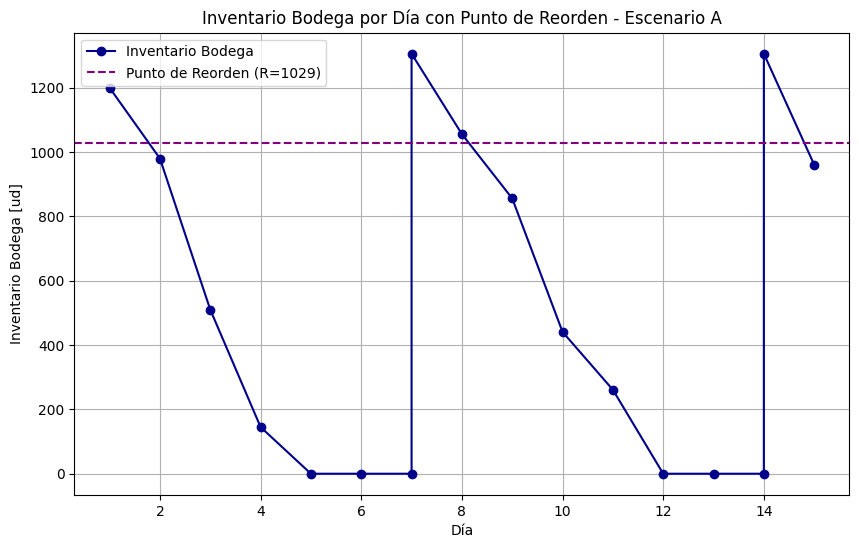

In [ ]:
## ESCENARIO A
QA = int(np.ceil(7*d_prom)) #Cantidad de lote [ud]
NsA = 0.75 #Nivel de servicio
LtA = 5 #Lead time [días]
dfA, inv_promedioA, costo_almacenajeA, can_no_venidasA, costo_inexistenciasA, costo_totalA,RA = SinBackOrders(QA,NsA,LtA)
print("ESCENARIO A")
print(tabulate(dfA, headers='keys', tablefmt='fancy_grid', showindex=False))
print(f"Inventario promedio: {inv_promedioA}")
print(f"Costo de almacenaje $: {costo_almacenajeA}")
print(f"Unidades no vendidas:  {can_no_venidasA}")
print(f"Costo de inexistencias $: {costo_inexistenciasA}")
print(f"Costo total $: {costo_totalA}")

plt.figure(figsize=(10, 6))
plt.plot(dfA["Día"], dfA["Inv. Bodega"], marker='o', color='darkblue', label='Inventario Bodega')
plt.axhline(y=RA, color='purple', linestyle='--', label=f'Punto de Reorden (R={RA})')
plt.xlabel("Día")
plt.ylabel("Inventario Bodega [ud]")
plt.title("Inventario Bodega por Día con Punto de Reorden - Escenario A")
plt.grid(True)
plt.legend()
plt.show()

**ESCENARIO B**

In [ ]:

## ESCENARIO B
QB = int(np.ceil(7*d_prom)) #Cantidad de lote [ud]
NsB = 0.99 #Nivel de servicio
LtB = 5 #Lead time [días]
dfB, inv_promedioB, costo_almacenajeB, can_no_venidasB, costo_inexistenciasB, costo_totalB,RB = SinBackOrders(QB,NsB,LtB)
print("ESCENARIO B")
print(tabulate(dfB, headers='keys', tablefmt='fancy_grid', showindex=False))
print(f"Inventario promedio: {inv_promedioB}")
print(f"Costo de almacenaje $: {costo_almacenajeB}")
print(f"Unidades no vendidas:  {can_no_venidasB}")
print(f"Costo de inexistencias $: {costo_inexistenciasB}")
print(f"Costo total $: {costo_totalB}")

ESCENARIO B
╒═══════╤═══════════╤═══════════════╤═════════════════╤══════════════╤═════════════════╤════════════════════════╤═══════════════════╕
│   Día │   Demanda │   Inv. Bodega │   Inv. Tránsito │   Inv. Total │   Orden Pedidos │   Recepción de pedidos │   Ud. No vendidas │
╞═══════╪═══════════╪═══════════════╪═════════════════╪══════════════╪═════════════════╪════════════════════════╪═══════════════════╡
│     1 │       220 │          1200 │               0 │         1200 │            1306 │                      0 │                 0 │
├───────┼───────────┼───────────────┼─────────────────┼──────────────┼─────────────────┼────────────────────────┼───────────────────┤
│     2 │       470 │           980 │            1306 │         2286 │               0 │                      0 │                 0 │
├───────┼───────────┼───────────────┼─────────────────┼──────────────┼─────────────────┼────────────────────────┼───────────────────┤
│     3 │       365 │           510 │            1

**ESCENARIO C**

In [ ]:
## ESCENARIO C
QC = int(np.ceil(10*d_prom)) #Cantidad de lote [ud]
NsC = 0.75 #Nivel de servicio
LtC = 5 #Lead time [días]
dfC, inv_promedioC, costo_almacenajeC, can_no_venidasC, costo_inexistenciasC, costo_totalC,RC = SinBackOrders(QC,NsC,LtC)
print("ESCENARIO C")
print(tabulate(dfC, headers='keys', tablefmt='fancy_grid', showindex=False))
print(f"Inventario promedio: {inv_promedioC}")
print(f"Costo de almacenaje $: {costo_almacenajeC}")
print(f"Unidades no vendidas:  {can_no_venidasC}")
print(f"Costo de inexistencias $: {costo_inexistenciasC}")
print(f"Costo total $: {costo_totalC}")

ESCENARIO C
╒═══════╤═══════════╤═══════════════╤═════════════════╤══════════════╤═════════════════╤════════════════════════╤═══════════════════╕
│   Día │   Demanda │   Inv. Bodega │   Inv. Tránsito │   Inv. Total │   Orden Pedidos │   Recepción de pedidos │   Ud. No vendidas │
╞═══════╪═══════════╪═══════════════╪═════════════════╪══════════════╪═════════════════╪════════════════════════╪═══════════════════╡
│     1 │       220 │          1200 │               0 │         1200 │               0 │                      0 │                 0 │
├───────┼───────────┼───────────────┼─────────────────┼──────────────┼─────────────────┼────────────────────────┼───────────────────┤
│     2 │       470 │           980 │               0 │          980 │            1865 │                      0 │                 0 │
├───────┼───────────┼───────────────┼─────────────────┼──────────────┼─────────────────┼────────────────────────┼───────────────────┤
│     3 │       365 │           510 │            1

**ESCENARIO D**


In [ ]:
## ESCENARIO D
QD = int(np.ceil(7*d_prom)) #Cantidad de lote [ud]
NsD = 0.75 #Nivel de servicio
LtD = 3 #Lead time [días]
dfD, inv_promedioD, costo_almacenajeD, can_no_venidasD, costo_inexistenciasD, costo_totalD,RD = SinBackOrders(QD,NsD,LtD)
print("ESCENARIO D")
print(tabulate(dfD, headers='keys', tablefmt='fancy_grid', showindex=False))
print(f"Inventario promedio: {inv_promedioD}")
print(f"Costo de almacenaje $: {costo_almacenajeD}")
print(f"Unidades no vendidas:  {can_no_venidasD}")
print(f"Costo de inexistencias $: {costo_inexistenciasD}")
print(f"Costo total $: {costo_totalD}")

ESCENARIO D
╒═══════╤═══════════╤═══════════════╤═════════════════╤══════════════╤═════════════════╤════════════════════════╤═══════════════════╕
│   Día │   Demanda │   Inv. Bodega │   Inv. Tránsito │   Inv. Total │   Orden Pedidos │   Recepción de pedidos │   Ud. No vendidas │
╞═══════╪═══════════╪═══════════════╪═════════════════╪══════════════╪═════════════════╪════════════════════════╪═══════════════════╡
│     1 │       220 │          1200 │               0 │         1200 │               0 │                      0 │                 0 │
├───────┼───────────┼───────────────┼─────────────────┼──────────────┼─────────────────┼────────────────────────┼───────────────────┤
│     2 │       470 │           980 │               0 │          980 │               0 │                      0 │                 0 │
├───────┼───────────┼───────────────┼─────────────────┼──────────────┼─────────────────┼────────────────────────┼───────────────────┤
│     3 │       365 │           510 │             

In [ ]:


Qs = [QA,QB,QC,QD]
Nss = [NsA, NsB, NsC, NsD]
LTT = [LtA, LtB, LtC, LtD]
Inv_pro = [inv_promedioA, inv_promedioB, inv_promedioC, inv_promedioD]
Cost_al = [costo_almacenajeA, costo_almacenajeB, costo_almacenajeC, costo_almacenajeD]
Cost_in = [costo_inexistenciasA, costo_inexistenciasB, costo_inexistenciasC, costo_inexistenciasD]
Cost_tot = [costo_totalA, costo_totalB, costo_totalC, costo_totalD]

data = {
    "Escenario": ["A", "B", "C", "D"],
    "Cantidad de lote (Q)": Qs,
    "Nivel de servicio (Ns)": Nss,
    "Lead time (Lt)": LTT,
    "Inventario promedio": Inv_pro,
    "Costo de almacenaje ($)": Cost_al,
    "Costo de inexistencias ($)": Cost_in,
    "Costo total ($)": Cost_tot
}

df_summary = pd.DataFrame(data)

print(tabulate(df_summary, headers='keys', tablefmt='fancy_grid', showindex=False))

╒═════════════╤════════════════════════╤══════════════════════════╤══════════════════╤═══════════════════════╤═══════════════════════════╤══════════════════════════════╤═══════════════════╕
│ Escenario   │   Cantidad de lote (Q) │   Nivel de servicio (Ns) │   Lead time (Lt) │   Inventario promedio │   Costo de almacenaje ($) │   Costo de inexistencias ($) │   Costo total ($) │
╞═════════════╪════════════════════════╪══════════════════════════╪══════════════════╪═══════════════════════╪═══════════════════════════╪══════════════════════════════╪═══════════════════╡
│ A           │                   1306 │                     0.75 │                5 │               601.467 │                   2105.13 │                         8195 │          10300.1  │
├─────────────┼────────────────────────┼──────────────────────────┼──────────────────┼───────────────────────┼───────────────────────────┼──────────────────────────────┼───────────────────┤
│ B           │                   1306 │          

In [ ]:
# Define plausible ranges for Q, Lt, and Ns
Q_values = [int(np.ceil(x * d_prom)) for x in [5, 7, 10, 12,13]]
Lt_values = [3, 5, 7, 2]
Ns_values = [0.75, 0.85, 0.90, 0.95, 0.99]

parameter_combinations = list(itertools.product(Q_values, Lt_values, Ns_values))

results = []

for combination in parameter_combinations:
    Q, Lt, Ns = combination
    df, inv_promedio, costo_almacenaje, can_no_venidas, costo_inexistencias, costo_total, R = SinBackOrders(Q, Ns, Lt)
    results.append((combination, costo_total))


min_cost = results[0][1]
best_combination = results[0][0]

for combination, costo_total in results:
    if costo_total < min_cost:
        min_cost = costo_total
        best_combination = combination

print(f"La combinación que minimiza el costo es : {best_combination}")
print(f"El menor costo total es : {min_cost}")

La combinación que minimiza el costo es : (933, 2, 0.95)
El menor costo total es : 4610.533333333333
